In [1]:
import os
import numpy as np
import pandas as pd


import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import matplotlib.patches as mpatches
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['font.sans-serif'] = "Arial" # missing fonts:: https://alexanderlabwhoi.github.io/post/2021-03-missingfont/
# Then, "ALWAYS use sans-serif fonts"
matplotlib.rcParams['font.family'] = "sans-serif"
matplotlib.rcParams.update({'font.size': 7, 'axes.linewidth': 1, 'xtick.major.width': 1, 'xtick.major.size': 5, 'ytick.major.width': 1, 'ytick.major.size': 5})
from matplotlib.backends.backend_pdf import PdfPages

In [2]:
def get_most_deleterious_idx(ser):
    all_masks = set(ser.unique())
    most_del = "Missense_lenient"
    if "pLoF" in all_masks:
        most_del = "pLoF"
    elif "Missense_strict" in all_masks:
        most_del = "Missense_strict"
    most_del_idx = ser.loc[ser==most_del].index[0]
    return most_del_idx


In [3]:
# keep most deleterious mask for sig genes
PROJECT_DIR = "/Users/deeprobanerjee/Documents/bmi_project/BMI_monogenic"

filename = os.path.join(PROJECT_DIR, "data/meta/results/all_ancestry/ivw_fixed/bmi_rint_monogenic_meta.tsv")
sig_meta_res_df = pd.read_csv(filename, sep="\t")
most_del_sig_meta_df = sig_meta_res_df.loc[sig_meta_res_df.groupby("gene")["gene_mask"].apply(get_most_deleterious_idx)].sort_values("beta", ascending=False).reset_index(drop=True)

# read previously calculated odds ratio file and keep most del masks
filename = os.path.join(PROJECT_DIR, "data/enrichment/comorbid/monogenic_enrich_comorbid.csv")
icd_df = pd.read_csv(filename)
icd_df = most_del_sig_meta_df.loc[:, ["gene", "gene_mask"]].merge(icd_df, on=["gene", "gene_mask"])



In [4]:
plot_df = icd_df.copy()
or_df = plot_df.pivot(index=["gene"], columns=["comorbidity"], values=["OR"]).loc[most_del_sig_meta_df.gene]
annot_df = plot_df.pivot(index=["gene"], columns=["comorbidity"], values=["p_value"]).loc[most_del_sig_meta_df.gene]

In [5]:
def get_star_values(pval):
    starp=""
    if pval<0.05/(len(most_del_sig_meta_df)*15):
        starp="*"
    return starp

annot_df = annot_df.applymap(lambda x: get_star_values(x))


In [6]:
def save_pdf(save_file, fig):
    os.makedirs(os.path.dirname(save_file), exist_ok=True)
    pdf = PdfPages(save_file)
    pdf.savefig(fig, bbox_inches='tight',dpi=300)
    pdf.close()
    return

In [7]:
or_dict = {
    "af": "Atrial fibrillation", 
    "avs": "Aortic valve stenosis",
    "cad": "Coronary artery disease",
    "ccs": "Cholecystitis",
    "cd": "Crohn's disease",
    "cls": "Cholelithiasis",
    "cvd": "Cardiovascular disease",
    "grd": "Gastroesophageal reflux disease",
    "hf": "Heart failure",
    "ht": "Hypertension",
    "koa": "Knee osteoarthritis",
    "nfld": "Nonalcoholic fatty liver disease",
    "pe": "Pulmonary embolism ",
    "t2d": "Type 2 diabetes",
    "vt": "Venous thromboembolism",
    }

In [8]:
or_df.columns = or_df.columns.get_level_values(1).map(or_dict)

/Users/deeprobanerjee/miniconda3/envs/analysis/lib/python3.10/site-packages/seaborn/matrix.py:1124: UserWarning: ``square=True`` ignored in clustermap
  warnings.warn(msg)


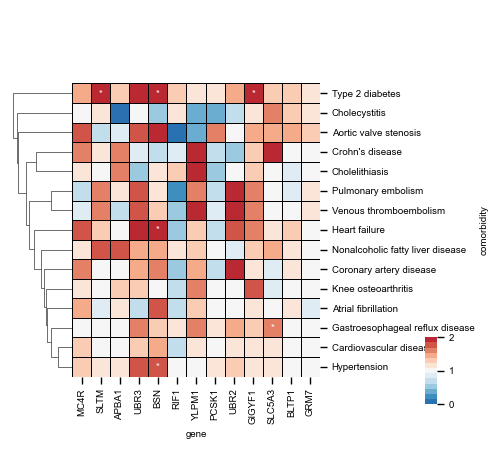

In [9]:
fig = sns.clustermap(
    or_df.T, center=1, cmap=sns.color_palette("RdBu_r", 15)[1:-1], 
    square=True, vmin=0, vmax=2, linewidth=0.5, linecolor="k", col_cluster=False, 
    annot=annot_df.T, fmt="s", 
    figsize=(5, 4.5), cbar_pos=(0.85, 0.1, 0.025, 0.15)
    )

In [10]:
filename = os.path.join(PROJECT_DIR, "data/enrichment/comorbid/comorbidities.pdf")
save_pdf(filename, fig.figure)